# Iskanje delovanj
V tem dokumentu predstavim uporabo diferencialnih enačb za iskanje delovanj in avtomorfizmov grafov.

## Delovanja
Iščemo model za homomorfizme $G=<S|R> \to S_n$. Naivno bi lahko vsak generator $s$ slikali v poljubno tabelo $\rho(s) = \begin{pmatrix} 
1 & 2 & \cdots & n \\
1^s & 2^s & \cdots & n^s 
\end{pmatrix}$ in spreminjali vrednosti $1^s, 2^s, \ldots, n^s $, da $\rho$ postane homomorfziem. Težava je, da so vrednosti v tabeli diskretne in gradientne metode optimizacije odpadejo. 

Rešitev je, da na prostoru funckij $S_n$ (ali pa na $\text{fun}([n], [n])$) uvedemo verjetnostno porazdelitev $P = P(\phi)$ in optimiziramo $P(\rho \text{ je homomorfizem}$.

Meni se zdita smiselna dva načina. Eden je bolj strojno učenjaški, eden pa je zelo podoben iskanju upodobitev.

## Matrični pristop
Vzenimo  model $\rho_\phi \colon G=<S|R> \to \text{dist}(\text{fun}([n], [n]))$, ki je definiram s tem, da vsakemu generatorju $s \in S$ dodeli matriko $\phi_s \in \mathbb R^{n \times n}$. *(Simetrično kot pri upodobitvah!!)*

Matriko $\phi_s$ pretvorimo v stohastično matriko $P_s=\begin{bmatrix} s_{i,j} \end{bmatrix}_{i, j = 1, \dots, n} := \text{softmax}_\text{po vrsticah} (\phi_s)$. 

S $P_s$ je določena porazdelitev nad $\text{fun}([n], [n])$. Na $s \in S$ lahko gledamo kot slučajno spremenljivko $s \in  \text{fun}([n], [n])$ in definiramo 
$$
P(s(i) = j) := s_{i, j}.
$$
Za poljubno deterministično funckijo $f \in \text{fun}([n], [n])$ definiramo še 
$$
 P(s = f) = \prod_{i=1}^n P(s(i) = f(i)) = \prod_{i=1}^n s_{i, f(i)}.
$$
S tem smo definirali model $\rho$, ki vsako matriko iz $\{\phi_s \mid s \in S\}$ slika v svojo slučajno spremenljivko $s \in \text{fun}([n], [n])$. 

Želeli bi, da je **$P(\rho \text{ je homomorfizem in ima lepe lastnosti})$** čim večja.

### $\mathcal L_{rel}$ - kaznujmo modele, ki niso homomomorfizmi
Naj bo $G=<S|R>$ in $r \in R$ beseda v generatorjih iz $R$. Na vsak generator lahko gledamo kot na slučajno funkcijo nad $[n]$. Podobno lahko tudi na $r$ gledamo kot na kompozitum svojih generatorjev. Velja še, da je matrika porazdelitve za $r$ enaka $P_r = \begin{bmatrix} P(r(i) = j) \end{bmatrix}_{i,j} = \prod _{s \in r} P_s$ produkt matrik porazdelitev generatorjev v $r$. 

Želimo si, da je $r$ kot slučajna funkcija skoraj zagotovo enaka identiteti, torej da je 
$$
P(r = \text{id}) = 1.
$$
Ekvivalentno: 
$$
0 = \log(P(r = \text{id})) = \log(\prod_{i=1}^n r_{i,i}) = \sum_{i=1}^n \log (r_{i,j}) = \text{trace} (\log(P_r)),
$$
kjer logaritem matrike računamo po elementih.
Za funckijo izgube lahko vzamemo

$\mathcal L_{rel} =- \text{trace} (\log(P_r)) =-
 \text{trace} (\log(\prod_{s \in r}  \text{softmax}(\phi_s)  ))$.

*Na nek način gre za maximal negative likelihood*.

In [21]:
# torch 
import torch
n = 3
# Dn



# za Dn --> Dn: 
phi = torch.tensor([[[0.19, 0.87, 0.43],
         [0.58, 0.23, 0.97],
         [0.57, 0.03, 1.00]],

        [[0.48, 0.64, 0.04],
         [0.47, 0.17, 0.84],
         [0.63, 0.53, 0.74]]], requires_grad=True)


# random : 
phi = torch.rand((2, n, n), requires_grad=True)


generators = {
'r' : 0, 's' :1
}
relations = ['r'*n, 's'*2, 'rsrs']

softmax = torch.nn.Softmax(dim=1)

def get_P(generator, phi):
    return softmax(phi[generators[generator]])



def loss_rel(generators, relations, phi):
    ans =torch.zeros((n,n))
    for r in relations:
        prod = torch.eye(n)
        for s in r:
            prod = prod @ softmax(phi[generators[s]])
        prod = torch.log(prod)
        ans += prod 
    return -ans.trace() 




print("Starting parameters: ", phi)


Starting parameters:  tensor([[[    0.50,     0.32,     0.11],
         [    0.49,     0.85,     0.66],
         [    0.52,     0.51,     0.52]],

        [[    0.13,     0.91,     0.05],
         [    0.80,     0.96,     0.95],
         [    0.45,     0.16,     0.00]]], requires_grad=True)


In [22]:
# training 
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

n_steps = 3000
opt = Adam([phi], lr= 0.01)
#scheduler = StepLR(opt, step_size=30, gamma=0.1)

for step in range(1, n_steps+1):
    opt.zero_grad()
    loss = loss_rel(generators, relations, phi)
    loss.backward()
    opt.step()
   # scheduler.step()
    if step % 500 == 1:
        print(f"Loss at step {step}: {loss.item()}")
    
    


Loss at step 1: 10.011245727539062
Loss at step 501: 0.2076064944267273
Loss at step 1001: 0.06668060272932053
Loss at step 1501: 0.03319280594587326
Loss at step 2001: 0.019616302102804184
Loss at step 2501: 0.012690717354416847


In [23]:
R = get_P('r', phi)
S = get_P('s', phi)
torch.set_printoptions(precision=2, sci_mode=False)
R, S

(tensor([[    1.00,     0.00,     0.00],
         [    0.00,     1.00,     0.00],
         [    0.00,     0.00,     1.00]], grad_fn=<SoftmaxBackward0>),
 tensor([[    0.00,     1.00,     0.00],
         [    1.00,     0.00,     0.00],
         [    0.00,     0.00,     1.00]], grad_fn=<SoftmaxBackward0>))

In [24]:
from scipy.optimize import linear_sum_assignment

def closest_permutation_matrix(M: torch.Tensor) -> torch.Tensor:
    # Convert to numpy for scipy
    M_np = M.detach().numpy()

    # Solve the linear sum assignment problem on the NEGATED matrix
    # (because we want to maximize the sum, but scipy minimizes)
    row_ind, col_ind = linear_sum_assignment(-M_np)

    # Create the permutation matrix
    n = M.size(0)
    P = torch.zeros_like(M)
    P[row_ind, col_ind] = 1.0
    return P

def permutation_from_matrix(X: torch.Tensor) -> torch.Tensor:
    table =X.argmax(dim=1) + 1 
    perm = {}
    for i in range(X.shape[0]):
        perm[i+1] = table[i].item()
    return perm


permutation_from_matrix(closest_permutation_matrix(R)), permutation_from_matrix(closest_permutation_matrix(S))


({1: 1, 2: 2, 3: 3}, {1: 2, 2: 1, 3: 3})

### $\mathcal L_{perm}$ - kaznujmo modele, ki niso permutacije
Podobno kot pri upodobitvah, ko definiramo funckijo izgube $\mathcal L_{unit}$, ki matrike optimizira v unitarne in s tem v obrnljive, lahko tukaj pomagamo $\mathcal L_{rel}$ s tem, da funckije "potiskamo" v bijekcije. 

Naj bo $s \in S$ generator. Radi bi, da je $s$ kot preslikava nad $[n]$ skoraj zagotovo bijekcija, torej 
$$
P(s \in S_n )= 1.
$$
Velja pa 
$$
P(s \in S_n )= \sum_{\sigma \in S_n} P(s = \sigma) = \sum_{\sigma \in S_n}   \prod_{i=1}^n s_{i, \sigma(i)}
= \text{Perm} (P_s).
$$
[Edine stohastične matrike z enotskim permanentom so permutacijske](https://math.stackexchange.com/questions/5063254/if-a-stochastic-matrix-has-unit-permanent-is-it-a-permutation-matrix), torej je 
$
P(s \in S_n )= 1.
$ natantko tedaj, ko je $P_s$ permutacijska. Za stohastične matrike pa je to ekvivalentno temu, da je $P_s$ **unitarna**. 

Za funkcijo izgube lahko vzamemo kar funckijo izgube za unitarnost, uporabljeno na matrikah $P_s$:
$$
\mathcal L_{perm} = \sum_{s \in S}||P_sP_s^*  - I||_F^2.
$$

### Avtomorfizmi grafov 
Naj bo $\mathcal G = ([n], E)$ graf na $n$ vozljiščih in $M=\begin{bmatrix}m_{i,j}\end{bmatrix}$ njegova matrika sosednosti. Naš model $\rho_\phi$ lahko spreminjamo v avtomorfizem grafa $\mathcal G$.

Za $(i,j) \in E$ računamo 
$$
P(i^s \sim j ^s) = \sum_{k= 1}^n \sum_{h = 1}^n s_{i, k} s_{j, h} m_{k,h} = s_j^T M s_i = (P_SMP_s^T)_{i,j}
$$
kjer je $P_s = \begin{bmatrix} s_1^T \\ \vdots \\ s_n^T \end{bmatrix}$.

Radi bi, da velja 
$
1 = \displaystyle\prod_{(i,j) \in E} P(i^s \sim j ^s).
$. 
Za funkcijo izgube lahko vzamemo
$$
\mathcal L_{aut} = -\sum_{i=1}^n\sum_{j=1}^n log(s_j^T M s_i)m_{i,j}= -\text{tr}(\log(P_sMP_s^T) M^T),
$$
kjer je $\log(SMS^T)$ izračunan po elementih.

Podoben premislek dela za poljubne morfizme grafov. Naj bo $M$ matrika sosednosti enega grafa in $N$ matrika sosednosti drugega. Velja $P(i^s \sim j ^s) = \sum_{k= 1}^n \sum_{h = 1}^n s_{i, k} s_{j, h} n_{k,h} = s_j^T N s_i$. Za loss izberemo 
$$
\mathcal L_{aut} = -\sum_{i=1}^n\sum_{j=1}^n log(s_j^T N s_i)m_{i,j}= -\text{tr}(\log(P_sNP_s^T) M^T)
$$

### Avtomorfizmi grafov - brez group
Verjetno je bolj smiselno iskati le avtomorfizme grafov. Vse isto, le pozabiš na $G$.

Demo: poiščimo kak avtomorfizem preporostega grafa:
![Demo graf](demo_graph.png)

In [ ]:
import itertools

def compose(p, q):
    """Return the composition p ∘ q (first q, then p) for permutations
    stored as tuples whose i-th entry is the image of i+1."""
    return tuple(p[q[i] - 1] for i in range(len(p)))

def inverse(p):
    """Inverse of a permutation given in tuple form."""
    inv = [0] * len(p)
    for i, x in enumerate(p):
        inv[x - 1] = i + 1
    return tuple(inv)

def cayley_Sn_edges(n: int):
    """
    Return the edge list of the (undirected) Cayley graph of S_n
    with generators a = (1 2) and b = (1 2 … n).  Vertices are
    indexed 0 … n!−1 in lexicographic order of permutations.
    Each edge is an ordered pair (i, j) with i < j.
    """
    if n < 2:
        raise ValueError("n must be at least 2")

    # all permutations of 1…n in lexicographic order
    perms = list(itertools.permutations(range(1, n + 1)))
    index = {p: k for k, p in enumerate(perms)}

    # generators
    a = tuple([2, 1, *range(3, n + 1)])          # (1 2)
    b = tuple([*range(2, n + 1), 1])             # (1 2 … n)
    b_inv = inverse(b)                           # (1 n … 2)

    edges = set()
    for p in perms:
        i = index[p]
        for g in (a, b, b_inv):
            j = index[compose(g, p)]
            if i < j:
                edges.add((i, j))

    # return a list sorted for reproducibility
    return sorted(edges)

cayley_Sn_edges(3)


[(0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 5), (2, 5), (3, 4), (4, 5)]

In [26]:
# torch

m=6
m=4
# prepare small graph
edges = [(0,1), (0,2), (1,2), (2, 3)]

#edges = cayley_Sn_edges(3)
M = torch.zeros((m,m))
for i, j in edges:
    M[i,j] = 1
    M[j, i] = 1

# primer, ko skonvergiramo:
Q = torch.tensor([[0.13, 0.34, 0.38, 0.23],
        [0.71, 0.22, 0.98, 0.84],
        [0.25, 0.52, 0.71, 0.59],
        [0.85, 0.93, 0.88, 0.64]], requires_grad=True)


# input:
Q = torch.rand((m,m), requires_grad=True)

def loss_aut(Q, M):
    P = softmax(Q)
    ans = P @ M @ P.transpose(0,1)
    ans = torch.log(ans )
    ans = ans @ M.transpose(0,1)
    return -ans.trace()

def loss_bijection(Q):
    P = softmax(Q)
    return torch.linalg.matrix_norm( P@ P.transpose(0,1) - torch.eye(P.shape[0]))**2


n_steps_aut = 3000
opt_aut = Adam([Q], lr=0.01)

print("Initial matrix: ", Q)

for step in range(1, n_steps_aut+1):
    opt_aut.zero_grad()
    loss =loss_aut(Q, M) + loss_bijection(Q)
    loss.backward()
    opt_aut.step()
    if step % 500 == 1:
        print(f"Loss at step {step}: {loss.item()}")


Initial matrix:  tensor([[0.13, 0.38, 0.72, 0.33],
        [0.45, 0.95, 0.30, 0.66],
        [0.58, 0.05, 0.37, 0.20],
        [0.53, 0.62, 0.80, 0.24]], requires_grad=True)
Loss at step 1: 8.085267066955566
Loss at step 501: 1.400468111038208
Loss at step 1001: 1.3016853332519531
Loss at step 1501: 1.2764768600463867
Loss at step 2001: 1.2658944129943848
Loss at step 2501: 1.2603845596313477


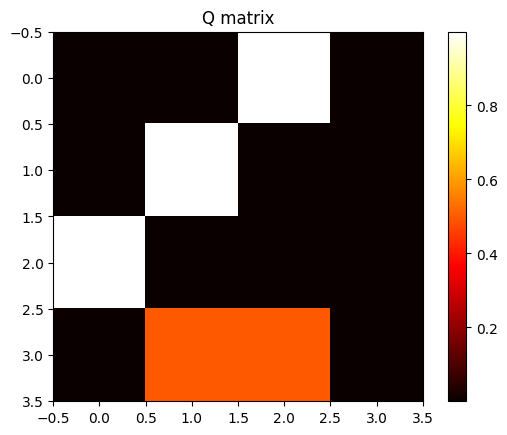

tensor([[    0.00,     0.00,     1.00,     0.00],
        [    0.00,     1.00,     0.00,     0.00],
        [    1.00,     0.00,     0.00,     0.00],
        [    0.00,     0.50,     0.50,     0.00]], grad_fn=<SoftmaxBackward0>)

In [27]:
import matplotlib.pyplot as plt 

plt.imshow(softmax(Q).detach().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Q matrix")
plt.show()
softmax(Q)

In [28]:
permutation_from_matrix(closest_permutation_matrix(Q.transpose(0,1)))

{1: 3, 2: 2, 3: 1, 4: 4}

## Strojnoučenjaški pristop
Namesto, da optimiziramo model $\rho \colon G \to \text{fun}([n], [n])$, naredimo model, ki že v začetku slika v $S_n$. (Podobno, kot smo pri upodobitvah naredili model, ki direktno slika v O(2)).

Velja $S_n = <a, b | R>$. Vsaka permutacija je torej beseda v $\{a, b\}$. 

Besede lahko gradimo rekurzivno. Definiramo model $M : S_n \to \text{bernulli}\{a, b\}$, ki za vsako permutacijo $\pi \in S_n$ vrne vektor verjetnosti  $[P(a | \pi), P(b | \pi), P(id | \pi)]$. S pomočjo tega modela lahko gradimo markovsko verigo:
- začneš z identiteto $\pi_0 = \text{id}$
- vsak korak iz porazdelitve  $[P(a | \pi_i), P(b | \pi_i), P(id | \pi)]$ vzorčiš generator $g \in \{a, b\}$. Če je $g$ identiteta, končaš in vrneš $\pi _i$, sicer pa nastaviš $\pi_{i+1} = \text{perm}(\pi_i \circ g)$,
kjer je $\text{perm}$ preslikava, ki besede slika v permutacije, ki jih besede predstavljajo (to je boljše, kot da model za vhod vzame besedo - besede so ppoljubno dolge in redundantne, permutacija pa je  vektor dimenzije $n$).

Za poljubno funckijo izgube $\mathcal L$ nad preslikavami  $G \mapsto S_n$ lahko minimaliziramo $E[\mathcal L (\rho)]$, kjer je $\rho$ zgoraj opisani slučjani proces.

Ta pristop je kul, ker se je z njim (v obliki $S \to aS  |bs | 1$) vse začelo.

# Kaj vse še lahko iščemo
## Poti na grafih z utežmi:
- najcenejša/najdražja pot, ki gre čez cel graf (to je lih funkcija)
- EULERJEVE POTI (in hamiltonove) - to so tud lih funkcije
- poljubne poti - to niso več funkcije, ampak besede na vozljiščih. mejbi glej drugi način? Če maš fkisno dolžino poti, pa lah delaš skor krkol
### Grafi
- mogoče lahko iščeš grafe z nekimi lastnostmi